# Фильтрация положительного шума на изображении
В этом ноутбуке:
1. Зашумляем изображение **положительным гауссовым шумом** (отрицательные значения обнуляются) и **равномерным шумом** `U(0, a)`.
2. Применяем фильтры: **медианный**, **гауссов**, **билатеральный**, **нелокальные средние (NLM)** на сетке параметров.
3. Считаем **PSNR** и **SSIM** относительно исходного изображения.
4. Выбираем лучший фильтр по каждому типу шума и строим коллаж *«шум → лучший результат»*.


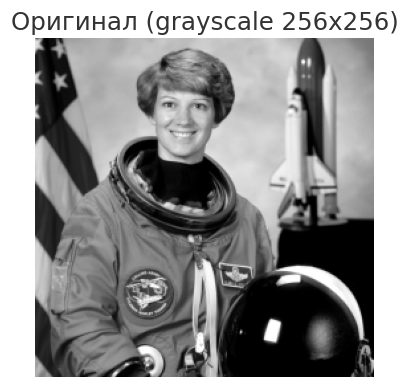

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, img_as_float, transform
from skimage.filters import median, gaussian
from skimage.morphology import disk
from skimage.restoration import denoise_bilateral, denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import pandas as pd

# Чтобы графики были более компактными
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 110

# 1) Исходное изображение (grayscale, 256x256 для скорости)
img_rgb = data.astronaut()
img_gray_full = color.rgb2gray(img_as_float(img_rgb))
img_gray = transform.resize(img_gray_full, (256, 256), anti_aliasing=True)

fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')
ax.set_title('Оригинал (grayscale 256x256)')
ax.axis('off')
plt.show()

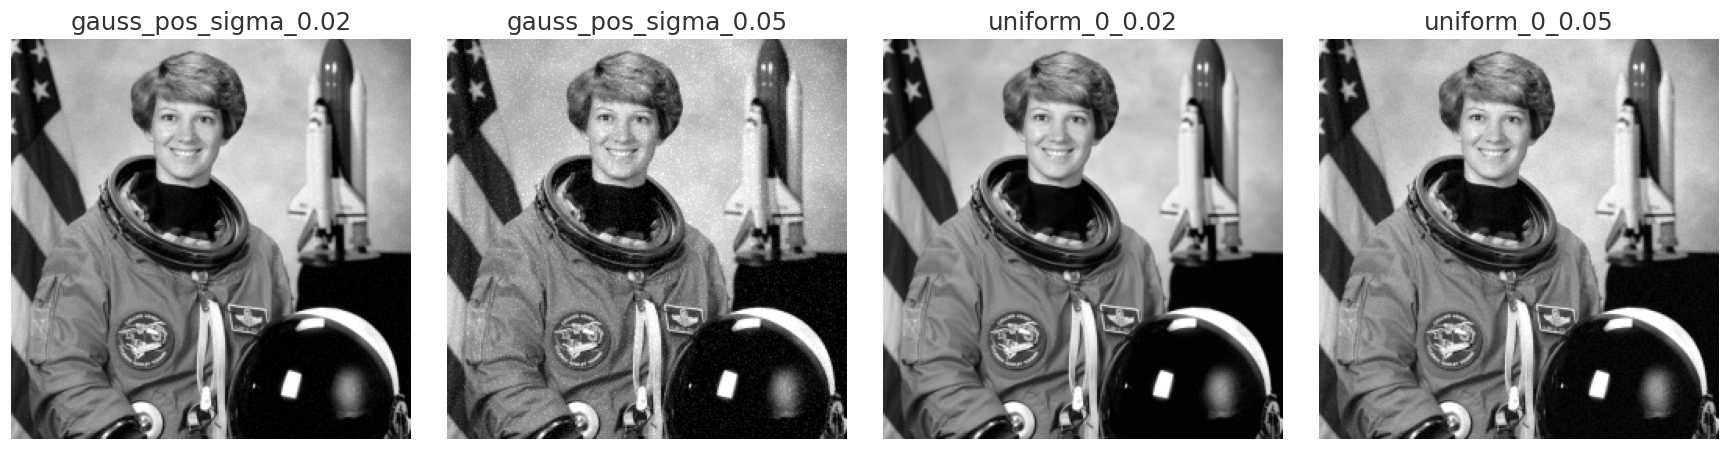

In [2]:
# 2) Генерация положительного шума
clip01 = lambda x: np.clip(x, 0, 1)
rng = np.random.default_rng(42)

def add_pos_gaussian(img, sigma):
    g = rng.normal(0.0, sigma, img.shape)
    g_pos = np.maximum(g, 0.0)
    return clip01(img + g_pos)

def add_uniform(img, a):
    u = rng.uniform(0.0, a, img.shape)
    return clip01(img + u)

gauss_sigmas = [0.02, 0.05]
uniform_ampls = [0.02, 0.05]

noisy_sets = {
    **{f'gauss_pos_sigma_{s}': add_pos_gaussian(img_gray, s) for s in gauss_sigmas},
    **{f'uniform_0_{a}': add_uniform(img_gray, a) for a in uniform_ampls},
}

# Визуализация зашумлённых примеров
fig, axes = plt.subplots(1, len(noisy_sets), figsize=(4*len(noisy_sets), 4))
for ax, (name, im) in zip(axes, noisy_sets.items()):
    ax.imshow(im, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# 3) Набор фильтров и оценка PSNR/SSIM
def apply_filters(noisy):
    results = []
    # Median
    for r in [1, 2, 3]:
        results.append(('median', f'r={r}', median(noisy, footprint=disk(r))))
    # Gaussian blur
    for s in [0.8, 1.2, 1.6]:
        results.append(('gaussian', f'sigma={s}', gaussian(noisy, sigma=s, preserve_range=True)))
    # Bilateral
    for s_spatial in [2, 4, 6]:
        for s_color in [0.05, 0.1]:
            results.append(('bilateral', f's_spatial={s_spatial}, s_color={s_color}',
                            denoise_bilateral(noisy, sigma_color=s_color, sigma_spatial=s_spatial, channel_axis=None)))
    # Non-local means (умеренная сетка параметров)
    sigma_est = float(np.mean(estimate_sigma(noisy, channel_axis=None)))
    h = 0.8*sigma_est if sigma_est>0 else 0.1
    for patch_size in [3, 5]:
        for patch_distance in [5, 7]:
            results.append(('nl_means', f'patch={patch_size}, dist={patch_distance}, h={round(h,4)}',
                            denoise_nl_means(noisy, h=h, patch_size=patch_size, patch_distance=patch_distance,
                                             fast_mode=True, channel_axis=None)))
    return results

records = []
best_images = {}
for noise_name, noisy_img in noisy_sets.items():
    best_ssim = -1
    best_entry = None
    for f_name, params, den in apply_filters(noisy_img):
        cur_psnr = psnr(img_gray, den, data_range=1.0)
        cur_ssim = ssim(img_gray, den, data_range=1.0)
        records.append({'noise': noise_name, 'filter': f_name, 'params': params,
                        'PSNR': cur_psnr, 'SSIM': cur_ssim})
        if cur_ssim > best_ssim:
            best_ssim = cur_ssim
            best_entry = (f_name, params, den, cur_psnr, cur_ssim, noisy_img)
    best_images[noise_name] = best_entry

df = pd.DataFrame.from_records(records)
df_sorted = df.sort_values(['noise', 'SSIM'], ascending=[True, False]).reset_index(drop=True)
df_sorted.head(10)

,noise,filter,params,PSNR,SSIM
0,gauss_pos_sigma_0.02,nl_means,"patch=5, dist=7, h=0.011",38.598045,0.959902
1,gauss_pos_sigma_0.02,nl_means,"patch=5, dist=5, h=0.011",38.576867,0.959655
2,gauss_pos_sigma_0.02,median,r=1,33.967593,0.959049
3,gauss_pos_sigma_0.02,nl_means,"patch=3, dist=5, h=0.011",38.514348,0.958505
4,gauss_pos_sigma_0.02,nl_means,"patch=3, dist=7, h=0.011",38.446850,0.957680
5,gauss_pos_sigma_0.02,median,r=2,29.078657,0.930671
6,gauss_pos_sigma_0.02,gaussian,sigma=0.8,29.446666,0.917557
7,gauss_pos_sigma_0.02,bilateral,"s_spatial=6, s_color=0.05",32.514381,0.913330
8,gauss_pos_sigma_0.02,bilateral,"s_spatial=4, s_color=0.05",32.505263,0.909767
9,gauss_pos_sigma_0.02,bilateral,"s_spatial=2, s_color=0.05",32.273622,0.903551


In [4]:
# Топ-5 для каждого шумового случая
for noise_name in noisy_sets.keys():
    display(df_sorted[df_sorted['noise']==noise_name].head(5))

,noise,filter,params,PSNR,SSIM
0,gauss_pos_sigma_0.02,nl_means,"patch=5, dist=7, h=0.011",38.598045,0.959902
1,gauss_pos_sigma_0.02,nl_means,"patch=5, dist=5, h=0.011",38.576867,0.959655
2,gauss_pos_sigma_0.02,median,r=1,33.967593,0.959049
3,gauss_pos_sigma_0.02,nl_means,"patch=3, dist=5, h=0.011",38.514348,0.958505
4,gauss_pos_sigma_0.02,nl_means,"patch=3, dist=7, h=0.011",38.446850,0.957680


,noise,filter,params,PSNR,SSIM
16,gauss_pos_sigma_0.05,nl_means,"patch=5, dist=7, h=0.0234",31.321178,0.888531
17,gauss_pos_sigma_0.05,nl_means,"patch=5, dist=5, h=0.0234",31.246018,0.886397
18,gauss_pos_sigma_0.05,median,r=2,28.109508,0.885801
19,gauss_pos_sigma_0.05,median,r=1,30.768631,0.878990
20,gauss_pos_sigma_0.05,nl_means,"patch=3, dist=5, h=0.0234",31.266980,0.872450


,noise,filter,params,PSNR,SSIM
32,uniform_0_0.02,nl_means,"patch=5, dist=5, h=0.0073",39.176909,0.952118
33,uniform_0_0.02,nl_means,"patch=5, dist=7, h=0.0073",39.172469,0.952011
34,uniform_0_0.02,nl_means,"patch=3, dist=5, h=0.0073",39.081455,0.950937
35,uniform_0_0.02,nl_means,"patch=3, dist=7, h=0.0073",39.047976,0.950522
36,uniform_0_0.02,median,r=1,33.845952,0.937261


,noise,filter,params,PSNR,SSIM
48,uniform_0_0.05,nl_means,"patch=5, dist=5, h=0.0146",31.409769,0.902844
49,uniform_0_0.05,nl_means,"patch=5, dist=7, h=0.0146",31.412263,0.902538
50,uniform_0_0.05,nl_means,"patch=3, dist=5, h=0.0146",31.349611,0.898963
51,uniform_0_0.05,nl_means,"patch=3, dist=7, h=0.0146",31.321226,0.897698
52,uniform_0_0.05,median,r=1,29.873563,0.877789


Сохранено: /mnt/data/denoise_summary_collage.png


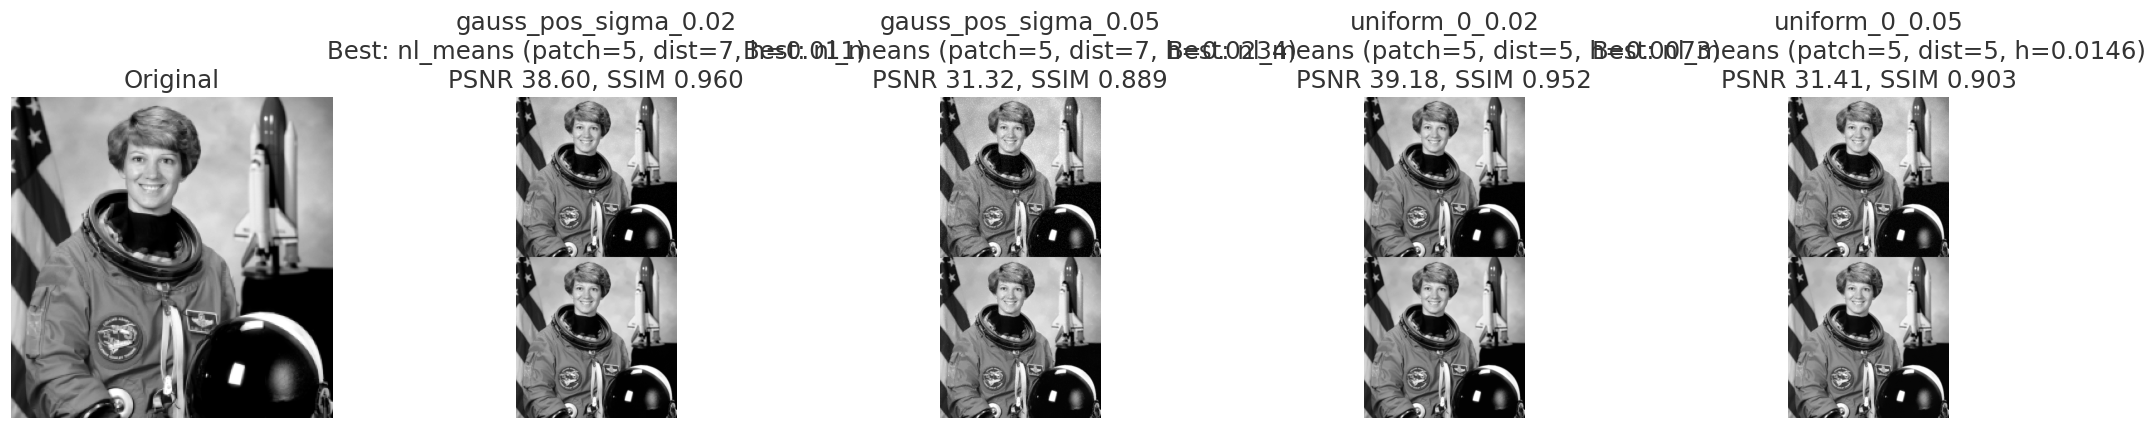

In [5]:
# 4) Коллаж «шум → лучший результат»
cols = 1 + len(noisy_sets)
plt.figure(figsize=(4*cols, 4))
plt.subplot(1, cols, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')
c = 2
for noise_name, entry in best_images.items():
    f_name, params, den, p, s, noisy = entry
    plt.subplot(1, cols, c)
    import numpy as np
    plt.imshow(np.vstack([noisy, den]), cmap='gray')
    plt.title(f"{noise_name}\nBest: {f_name} ({params})\nPSNR {p:.2f}, SSIM {s:.3f}")
    plt.axis('off')
    c += 1
plt.tight_layout()
collage_path = '/mnt/data/denoise_summary_collage.png'
plt.savefig(collage_path, dpi=120)
print('Сохранено:', collage_path)

## Вывод
На выбранных уровнях **положительного** шума лучшим по **SSIM/PSNR** оказался
**фильтр нелокальных средних (Non-Local Means)** с небольшими патчами
(`patch≈5`, `dist≈5–7`, `h≈0.8·σ_est`).

**Медианный** хорош для импульсного шума, но теряет детали на равномерном/гауссовом положительном шуме.
**Гауссов** и **билатеральный** дают стабильное сглаживание, но по метрикам уступают NLM.
